In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

# Recency, Frequency, and Monetary Analysis

In [ ]:
df = pd.read_csv('/content/Retail_Data_Transactions.csv')
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,11-Feb-13,35
1,CS4768,15-Mar-15,39
2,CS2122,26-Feb-13,52
3,CS1217,16-Nov-11,99
4,CS1850,20-Nov-13,78


In [ ]:
df.isna().sum()

customer_id    0
trans_date     0
tran_amount    0
dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   customer_id  125000 non-null  object
 1   trans_date   125000 non-null  object
 2   tran_amount  125000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.9+ MB


In [ ]:
df['trans_date'] = pd.to_datetime(df['trans_date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125000 entries, 0 to 124999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   customer_id  125000 non-null  object        
 1   trans_date   125000 non-null  datetime64[ns]
 2   tran_amount  125000 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.9+ MB


In [ ]:
df.head()

,customer_id,trans_date,tran_amount
0,CS5295,2013-02-11,35
1,CS4768,2015-03-15,39
2,CS2122,2013-02-26,52
3,CS1217,2011-11-16,99
4,CS1850,2013-11-20,78


In [ ]:
df.describe()

,tran_amount
count,125000.000000
mean,64.991912
std,22.860006
min,10.000000
25%,47.000000
50%,65.000000
75%,83.000000
max,105.000000


array([[<Axes: title={'center': 'tran_amount'}>]], dtype=object)

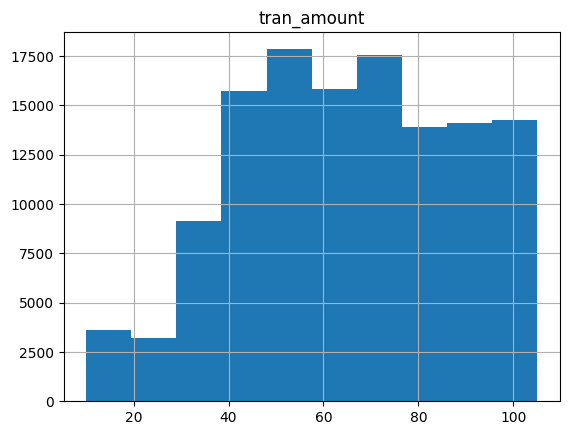

In [ ]:
hist = df[['tran_amount']].hist()
hist

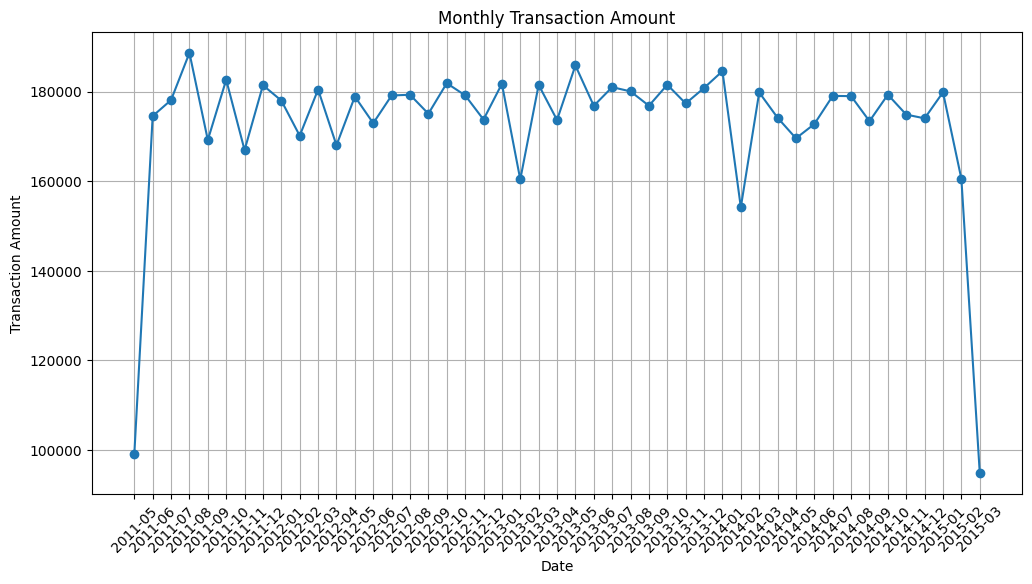

In [ ]:
import matplotlib.pyplot as plt

df['Month'] = df['trans_date'].dt.to_period('M')
monthly_amounts = df.groupby('Month')['tran_amount'].sum()

monthly_amounts.index = monthly_amounts.index.astype(str)

plt.figure(figsize=(12,6))
plt.plot(monthly_amounts.index, monthly_amounts.values, marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Transaction Amount')
plt.title('Monthly Transaction Amount')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

In [ ]:
snapshot_date = df['trans_date'].max() + dt.timedelta(days=1)

# Create an RFM table
rfm_table = df.groupby('customer_id').agg({
    'trans_date': lambda x: (snapshot_date - x.max()).days,
    'tran_amount': 'sum'
})

# Rename the columns
rfm_table.rename(columns={
    'trans_date': 'Recency',
    'tran_amount': 'Monetary'
}, inplace=True)

print('snapshot date:', snapshot_date)
rfm_table.head()

snapshot date: 2015-03-17 00:00:00


,Recency,Monetary
customer_id,,
CS1112,62,1012
CS1113,36,1490
CS1114,33,1432
CS1115,12,1659
CS1116,204,857


In [ ]:
# Calculate frequency (total number of transactions) for each customer
frequency_table = df['customer_id'].value_counts().reset_index()
frequency_table.columns = ['customer_id', 'Frequency']

frequency_table

,customer_id,Frequency
0,CS4424,39
1,CS4320,38
2,CS3799,36
3,CS1215,35
4,CS5109,35
...,...,...
6884,CS8559,4
6885,CS7716,4
6886,CS8376,4
6887,CS7224,4


In [ ]:
# Merge the frequency_table with rfm_table
rfm_table = rfm_table.merge(frequency_table, on ='customer_id')

# Adjust the column order
rfm_table = rfm_table[['customer_id', 'Recency', 'Frequency', 'Monetary']]

# Display the RFM table
rfm_table.head()

,customer_id,Recency,Frequency,Monetary
0,CS1112,62,15,1012
1,CS1113,36,20,1490
2,CS1114,33,19,1432
3,CS1115,12,22,1659
4,CS1116,204,13,857


In [ ]:
df[df.customer_id == 'CS1112'].sort_values(by=['trans_date'])

,customer_id,trans_date,tran_amount,Month
77247,CS1112,2011-06-15,56,2011-06
89149,CS1112,2011-08-19,96,2011-08
68206,CS1112,2011-10-02,60,2011-10
36486,CS1112,2012-04-08,56,2012-04
93074,CS1112,2012-06-24,52,2012-06
67735,CS1112,2012-07-03,81,2012-07
89734,CS1112,2012-09-16,72,2012-09
40368,CS1112,2012-12-15,76,2012-12
87839,CS1112,2013-03-01,105,2013-03
42084,CS1112,2013-07-01,36,2013-07


In [ ]:
# Create quantiles for each RFM attribute
quantiles = rfm_table.quantile(q=[0.25, 0.5, 0.75])

# Define a function to assign scores based on quartiles
def rfm_score(x, attribute, quantiles, reverse=False):
  if not reverse:
    if x <= quantiles[attribute][0.25]:
      return 1
    elif x <= quantiles[attribute][0.5]:
      return 2
    elif x <= quantiles[attribute][0.75]:
      return 3
    else:
      return 4
  else:
    if x <= quantiles[attribute][0.25]:
      return 4
    elif x <= quantiles[attribute][0.5]:
      return 3
    elif x <= quantiles[attribute][0.75]:
      return 2
    else:
      return 1

# Calculate RFM scores
rfm_table["R"] = rfm_table["Recency"].apply(rfm_score, args=("Recency", quantiles,True))
rfm_table["F"] = rfm_table["Frequency"].apply(rfm_score, args=("Frequency", quantiles,))
rfm_table["M"] = rfm_table["Monetary"].apply(rfm_score, args=("Monetary", quantiles,))

# Combine the RFM scores into a single RFM segment
rfm_table["RFM_Segment"] = rfm_table["R"].map(str) + rfm_table["F"].map(str) + rfm_table["M"].map(str)

# Calculate the RFM score sum
rfm_table["RFM_Score"] = rfm_table["R"] + rfm_table["F"] + rfm_table["M"]

rfm_table.head()

<ipython-input-14-ea53151a6d7f>:2: FutureWarning: The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  quantiles = rfm_table.quantile(q=[0.25, 0.5, 0.75])


,customer_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
0,CS1112,62,15,1012,2,2,2,222,6
1,CS1113,36,20,1490,3,3,3,333,9
2,CS1114,33,19,1432,3,3,3,333,9
3,CS1115,12,22,1659,4,3,4,434,11
4,CS1116,204,13,857,1,1,2,112,4


In [ ]:
quantiles

,Recency,Frequency,Monetary
0.25,23.0,14.0,781.0
0.50,54.0,18.0,1227.0
0.75,112.0,22.0,1520.0


In [ ]:
# Define the segment mapping
segment_mapping = {
    "111": "Lost",
    "112": "Lost",
    "113": "Lost",
    "114": "Lost",
    "121": "Lost",
    "122": "Lost",
    "123": "Lost",
    "124": "Lost",
    "131": "Lost",
    "132": "Lost",
    "133": "Lost",
    "134": "Lost",
    "141": "Lost",
    "142": "Lost",
    "143": "Lost",
    "144": "Lost",
    "211": "Potential Loyalists",
    "212": "Potential Loyalists",
    "213": "Potential Loyalists",
    "214": "Potential Loyalists",
    "221": "Promising",
    "222": "Promising",
    "223": "Promising",
    "224": "Promising",
    "231": "Promising",
    "232": "Promising",
    "233": "Promising",
    "234": "Promising",
    "241": "Promising",
    "242": "Promising",
    "243": "Promising",
    "244": "Promising",
    "311": "Needs Attention",
    "312": "Needs Attention",
    "313": "Needs Attention",
    "314": "Needs Attention",
    "321": "Needs Attention",
    "322": "Needs Attention",
    "323": "Needs Attention",
    "324": "Needs Attention",
    "331": "Needs Attention",
    "332": "Needs Attention",
    "333": "Needs Attention",
    "334": "Needs Attention",
    "341": "Needs Attention",
    "342": "Needs Attention",
    "343": "Needs Attention",
    "344": "Needs Attention",
    "411": "Loyal Customers",
    "412": "Loyal Customers",
    "413": "Loyal Customers",
    "414": "Loyal Customers",
    "421": "Loyal Customers",
    "422": "Loyal Customers",
    "423": "Loyal Customers",
    "424": "Loyal Customers",
    "431": "Loyal Customers",
    "432": "Loyal Customers",
    "433": "Loyal Customers",
    "434": "Loyal Customers",
    "441": "Champion",
    "442": "Champion",
    "443": "Champion",
    "444": "Champion"
}

# Map RFM segments to customer segments
rfm_table["Segment"] = rfm_table["RFM_Segment"].map(segment_mapping)

# Display the updated RFM table with segments
rfm_table.head()

,customer_id,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
0,CS1112,62,15,1012,2,2,2,222,6,Promising
1,CS1113,36,20,1490,3,3,3,333,9,Needs Attention
2,CS1114,33,19,1432,3,3,3,333,9,Needs Attention
3,CS1115,12,22,1659,4,3,4,434,11,Loyal Customers
4,CS1116,204,13,857,1,1,2,112,4,Lost


In [ ]:
segment_count = rfm_table['Segment'].value_counts().reset_index()
segment_count

,index,Segment
0,Lost,1711
1,Needs Attention,1665
2,Promising,1327
3,Loyal Customers,1317
4,Champion,464
5,Potential Loyalists,405


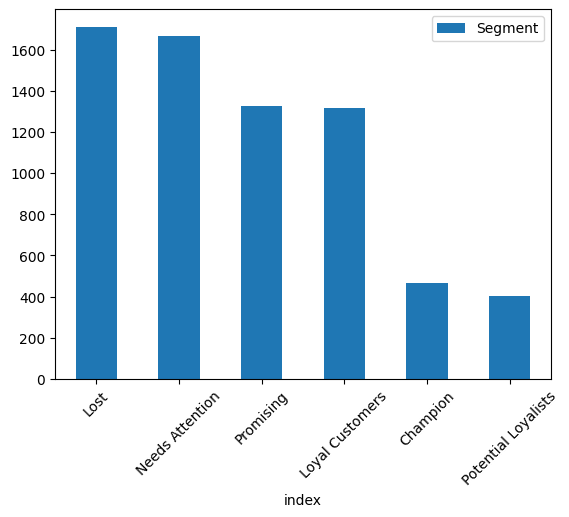

In [ ]:
ax = segment_count.plot.bar(x='index', y='Segment', rot=45)

# Neural Network

In [ ]:
df2 = pd.read_csv('/content/diabetes.csv')
df2

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
df2.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [ ]:
df2_remove_zero = df2.copy()
df2_remove_zero[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']] = df2_remove_zero[['Glucose','BloodPressure','SkinThickness','Insulin','BMI']].replace(0,np.NaN)

In [ ]:
total = df2_remove_zero.isnull().sum().sort_values(ascending=False)
percent = (df2_remove_zero.isnull().sum()/df2_remove_zero.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total,percent], axis=1, keys=['Total','Percent'])
missing_data.head(20)

,Total,Percent
Insulin,374,0.486979
SkinThickness,227,0.295573
BloodPressure,35,0.045573
BMI,11,0.014323
Glucose,5,0.006510
Pregnancies,0,0.000000
DiabetesPedigreeFunction,0,0.000000
Age,0,0.000000
Outcome,0,0.000000


In [ ]:
df2_remove_zero[df2_remove_zero.duplicated()]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome


array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

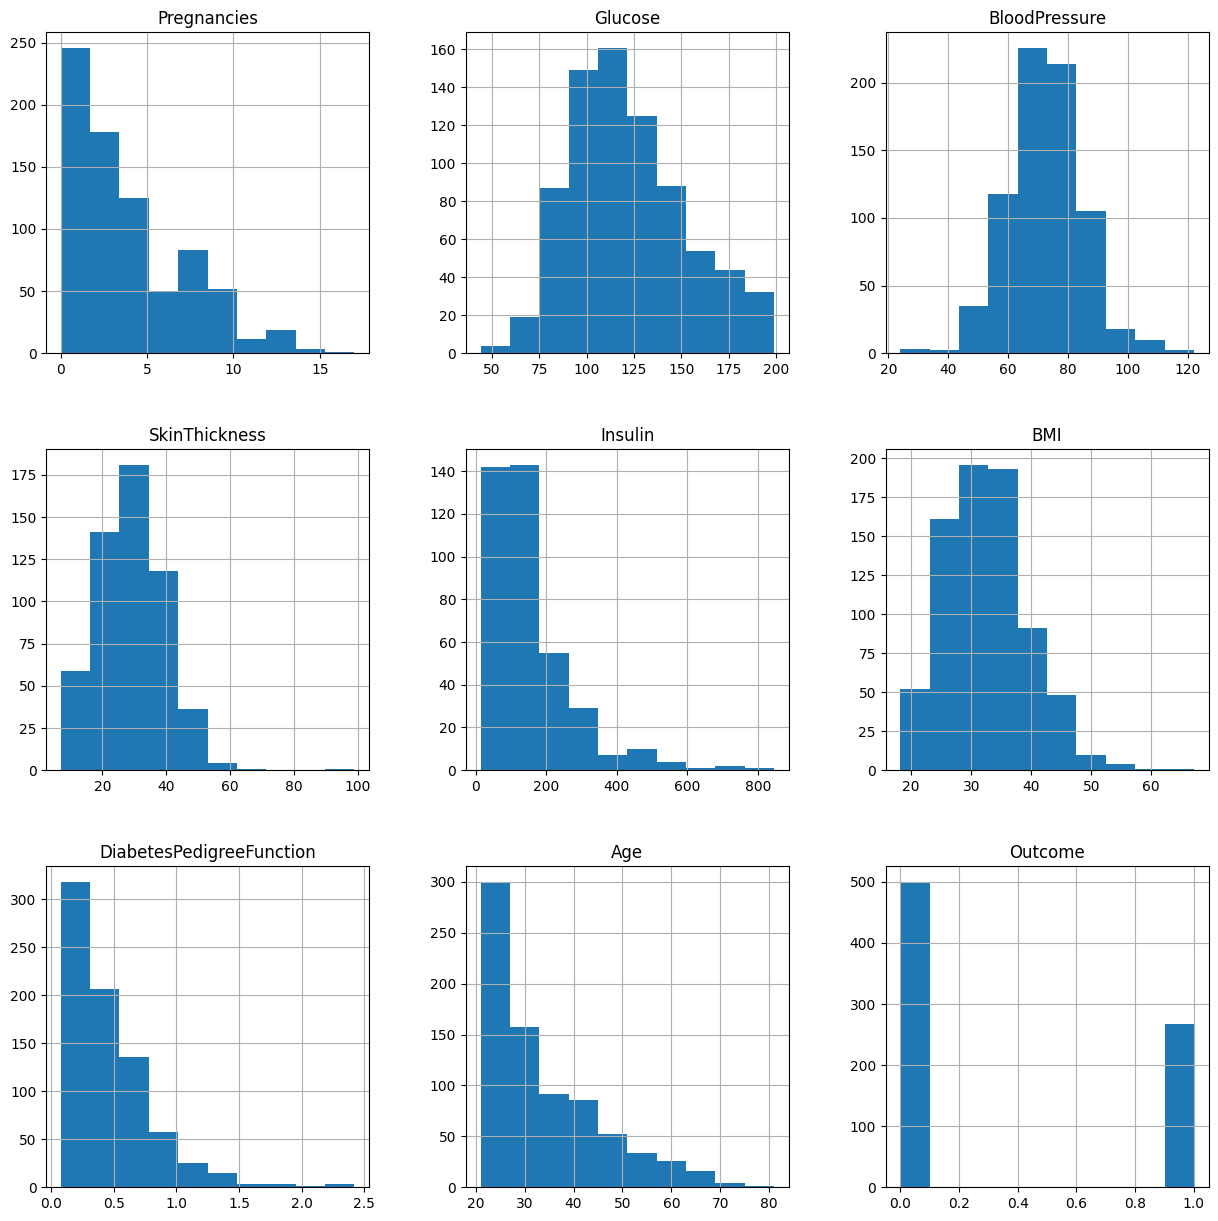

In [ ]:
df2_remove_zero.hist(figsize = (15,15))

In [ ]:
df2_remove_zero['Glucose'].fillna(df2_remove_zero['Glucose'].median(), inplace = True)
df2_remove_zero['BloodPressure'].fillna(df2_remove_zero['BloodPressure'].median(), inplace = True)
df2_remove_zero['SkinThickness'].fillna(df2_remove_zero['SkinThickness'].median(), inplace = True)
df2_remove_zero['Insulin'].fillna(df2_remove_zero['Insulin'].median(), inplace = True)
df2_remove_zero['BMI'].fillna(df2_remove_zero['Insulin'].median(), inplace = True)

array([[<Axes: title={'center': 'Pregnancies'}>,
        <Axes: title={'center': 'Glucose'}>,
        <Axes: title={'center': 'BloodPressure'}>],
       [<Axes: title={'center': 'SkinThickness'}>,
        <Axes: title={'center': 'Insulin'}>,
        <Axes: title={'center': 'BMI'}>],
       [<Axes: title={'center': 'DiabetesPedigreeFunction'}>,
        <Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'Outcome'}>]], dtype=object)

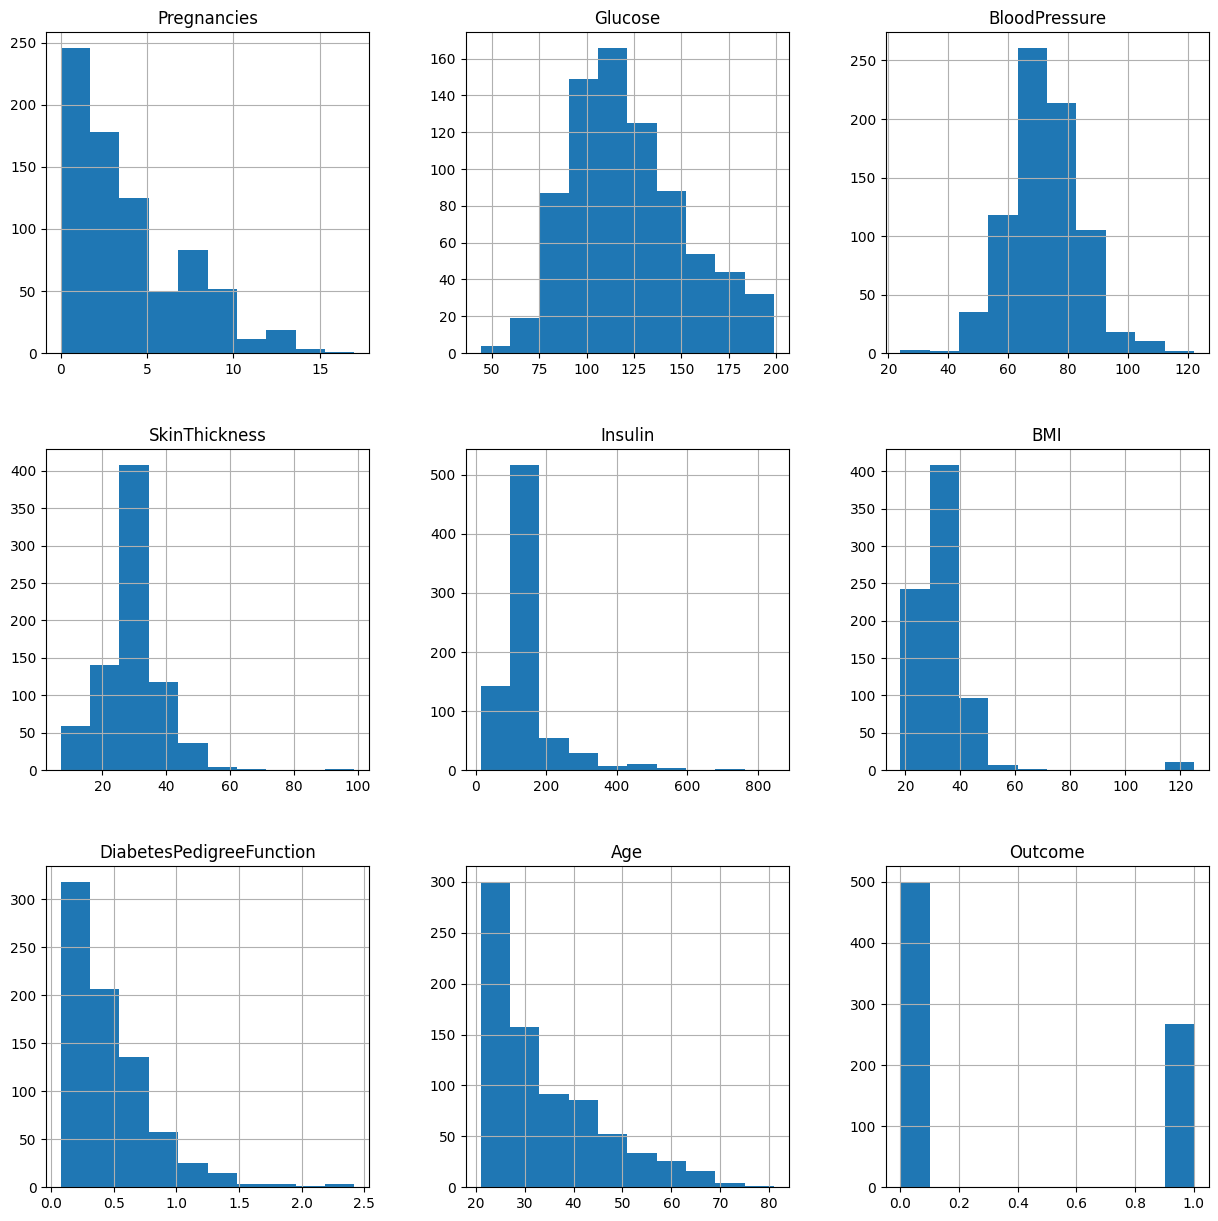

In [ ]:
df2_remove_zero.hist(figsize=(15,15))

In [ ]:
x1 = df2.iloc[:,0:-1].values
y1 = df2.iloc[:,-1].values

In [ ]:
from sklearn.model_selection import train_test_split

x1_train, x1_test, y1_train, y1_test = train_test_split(x1, y1, test_size = 0.25, random_state = 42)

In [ ]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
x1_train_scaled = sc.fit_transform(x1_train)
x1_test_scaled = sc.transform(x1_test)

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

# Build the neural network model
model = Sequential()
model.add(Dense(10, input_dim=8, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience = 5)

In [ ]:
# Define the model checkpoint callback
model_checkpoint = ModelCheckpoint('best_model.h5', monitor ='val_loss', save_best_only=True, mode='min')

In [ ]:
# Train the model
model.fit(x1_train_scaled, y1_train, epochs=50, batch_size=2, validation_data=(x1_test_scaled, y1_test), callbacks=[early_stopping, model_checkpoint])

Epoch 1/50
288/288 [==============================] - 2s 3ms/step - loss: 0.6310 - accuracy: 0.6719 - val_loss: 0.5899 - val_accuracy: 0.7552
Epoch 2/50
288/288 [==============================] - 1s 2ms/step - loss: 0.5299 - accuracy: 0.7500 - val_loss: 0.5380 - val_accuracy: 0.7500
Epoch 3/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4870 - accuracy: 0.7674 - val_loss: 0.5266 - val_accuracy: 0.7708
Epoch 4/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4673 - accuracy: 0.7708 - val_loss: 0.5239 - val_accuracy: 0.7604
Epoch 5/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4569 - accuracy: 0.7587 - val_loss: 0.5276 - val_accuracy: 0.7396
Epoch 6/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4488 - accuracy: 0.7812 - val_loss: 0.5280 - val_accuracy: 0.7448
Epoch 7/50
288/288 [==============================] - 1s 2ms/step - loss: 0.4441 - accuracy: 0.7812 - val_loss: 0.5290 - val_accuracy: 0.7604
Epoch 

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Evaluate the model
y_pred = model.predict(x1_test_scaled)
y_pred = (y_pred > 0.5).astype(int)
cm = confusion_matrix(y1_test,y_pred)
report = classification_report(y1_test, y_pred)
print(cm)
print(report)

6/6 [==============================] - 0s 3ms/step
[[103  20]
 [ 24  45]]
              precision    recall  f1-score   support

           0       0.81      0.84      0.82       123
           1       0.69      0.65      0.67        69

    accuracy                           0.77       192
   macro avg       0.75      0.74      0.75       192
weighted avg       0.77      0.77      0.77       192



In [ ]:
model.predict(x1_test_scaled)

6/6 [==============================] - 0s 2ms/step


array([[0.23567939],
       [0.04289742],
       [0.058819  ],
       [0.2628871 ],
       [0.46395472],
       [0.4134393 ],
       [0.00506656],
       [0.604396  ],
       [0.6717498 ],
       [0.518056  ],
       [0.21264559],
       [0.79163027],
       [0.27985054],
       [0.36716193],
       [0.03077621],
       [0.4839168 ],
       [0.07549613],
       [0.03776682],
       [0.7350618 ],
       [0.68855184],
       [0.30688044],
       [0.0471207 ],
       [0.39399606],
       [0.0177926 ],
       [0.5505905 ],
       [0.8820557 ],
       [0.06447367],
       [0.02204262],
       [0.1180715 ],
       [0.23734416],
       [0.9003262 ],
       [0.5995946 ],
       [0.7944788 ],
       [0.7637574 ],
       [0.5553451 ],
       [0.7808454 ],
       [0.8889032 ],
       [0.17686868],
       [0.3367428 ],
       [0.6340957 ],
       [0.04924714],
       [0.2663357 ],
       [0.40714803],
       [0.39659336],
       [0.05250213],
       [0.64160144],
       [0.54533   ],
       [0.152